# 1b) Smart sampling the parameter space

From the set of parameters estimated using multiple patch recordings (1 somatic, 2 apical dendrites), we simulate random perturbations using Latin Hypercube Sampling (LHS). 

First, we generate a large number of samples, then we select the samples which:

- are the most distant between each other
- which reproduce bAP firing
- whose feature sets are also the most distant 

The random parameters are saved in the `config/params/smart_random.csv` and will be used to assess the fitting performance of different feature sets.

In [64]:
%load_ext autoreload
%autoreload

from pyDOE import lhs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import json
from pathlib import Path
from scipy.spatial import distance
import MEAutility as mu
import LFPy
from copy import copy

import bluepyopt as bpopt
import bluepyopt.ephys as ephys

%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import l5pc_model
import l5pc_evaluator
import l5pc_plot

In [3]:
save_params = False

In [4]:
release_params = {
    'gNaTs2_tbar_NaTs2_t.apical': 0.026145,
    'gSKv3_1bar_SKv3_1.apical': 0.004226,
    'gImbar_Im.apical': 0.000143,
    'gNaTa_tbar_NaTa_t.axonal': 3.137968,
    'gK_Tstbar_K_Tst.axonal': 0.089259,
    'gamma_CaDynamics_E2.axonal': 0.002910,
    'gNap_Et2bar_Nap_Et2.axonal': 0.006827,
    'gSK_E2bar_SK_E2.axonal': 0.007104,
    'gCa_HVAbar_Ca_HVA.axonal': 0.000990,
    'gK_Pstbar_K_Pst.axonal': 0.973538,
    'gSKv3_1bar_SKv3_1.axonal': 1.021945,
    'decay_CaDynamics_E2.axonal': 287.198731,
    'gCa_LVAstbar_Ca_LVAst.axonal': 0.008752,
    'gamma_CaDynamics_E2.somatic': 0.000609,
    'gSKv3_1bar_SKv3_1.somatic': 0.303472,
    'gSK_E2bar_SK_E2.somatic': 0.008407,
    'gCa_HVAbar_Ca_HVA.somatic': 0.000994,
    'gNaTs2_tbar_NaTs2_t.somatic': 0.983955,
    'decay_CaDynamics_E2.somatic': 210.485284,
    'gCa_LVAstbar_Ca_LVAst.somatic': 0.000333
}

# load param configs for boundary values
param_configs = json.load(open('config/parameters.json'))

In [5]:
n_params = len(release_params)
n_samples = 500  # number of random samples 
lim_dev = 0.2  # limits for each param are: [release_val-lim_dev*release_val, release_val+lim_dev*release_val] 

### Latin hypercube sampling (normal 0-1)

In [6]:
random_samples = lhs(n_params, samples=n_samples)

<IPython.core.display.Javascript object>


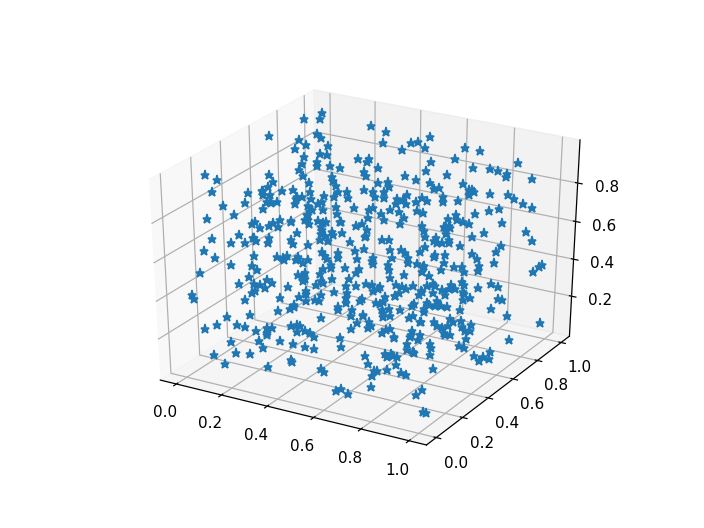

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(random_samples[:, 5], random_samples[:, 19], random_samples[:, 3], '*')

### Compute parameters limits

In [12]:
param_lims = {}

for par, val in release_params.items():
    dev = lim_dev * val
    lims = [val - dev, val + dev]
    
    # check values based on param configs
    for param in param_configs:
        name, loc = par.split('.')
        if param['param_name'] == name and param['sectionlist'] == loc:
            if 'bounds' in param:
                if lims[0] < param['bounds'][0]:
                    lims[0] = param['bounds'][0]
                    print(f'Param {par} changed lower bound')                    
                if lims[1] > param['bounds'][1]:
                    lims[1] = param['bounds'][1]
                    print(f'Param {par} changed upper bound')
    param_lims[par] = lims

Param gK_Tstbar_K_Tst.axonal changed upper bound
Param gCa_HVAbar_Ca_HVA.axonal changed upper bound
Param gK_Pstbar_K_Pst.axonal changed upper bound
Param gCa_LVAstbar_Ca_LVAst.axonal changed upper bound
Param gamma_CaDynamics_E2.somatic changed lower bound
Param gCa_HVAbar_Ca_HVA.somatic changed upper bound
Param gNaTs2_tbar_NaTs2_t.somatic changed upper bound


In [13]:
param_lims

{'gNaTs2_tbar_NaTs2_t.apical': [0.020916, 0.031374],
 'gSKv3_1bar_SKv3_1.apical': [0.0033807999999999998, 0.0050712],
 'gImbar_Im.apical': [0.0001144, 0.0001716],
 'gNaTa_tbar_NaTa_t.axonal': [2.5103744, 3.7655616],
 'gK_Tstbar_K_Tst.axonal': [0.0714072, 0.1],
 'gamma_CaDynamics_E2.axonal': [0.0023279999999999998, 0.003492],
 'gNap_Et2bar_Nap_Et2.axonal': [0.0054616, 0.008192399999999999],
 'gSK_E2bar_SK_E2.axonal': [0.0056832, 0.0085248],
 'gCa_HVAbar_Ca_HVA.axonal': [0.000792, 0.001],
 'gK_Pstbar_K_Pst.axonal': [0.7788304, 1],
 'gSKv3_1bar_SKv3_1.axonal': [0.8175560000000001, 1.226334],
 'decay_CaDynamics_E2.axonal': [229.7589848, 344.6384772],
 'gCa_LVAstbar_Ca_LVAst.axonal': [0.007001599999999999, 0.01],
 'gamma_CaDynamics_E2.somatic': [0.0005, 0.0007308],
 'gSKv3_1bar_SKv3_1.somatic': [0.2427776, 0.3641664],
 'gSK_E2bar_SK_E2.somatic': [0.0067256, 0.010088399999999999],
 'gCa_HVAbar_Ca_HVA.somatic': [0.0007952, 0.001],
 'gNaTs2_tbar_NaTs2_t.somatic': [0.787164, 1],
 'decay_CaDynam

### Scale parameters

In [14]:
scaled_samples = np.zeros_like(random_samples)

for i, sample in enumerate(random_samples):
    for j, (par, parlim) in enumerate(param_lims.items()):
        scaled_samples[i, j] = (parlim[1] - parlim[0]) * sample[j] + parlim[0] 

In [15]:
for sample in scaled_samples:
    for j, (par, parlim) in enumerate(param_lims.items()):
        assert parlim[0] < sample[j] < parlim[1] 

## Select *distant* parameters

First we iteratively look for parameters distan from each other in the original normalized space.

In [43]:
num_target_samples = 50
min_dist = 0.2
target_samples_idxs = []
it = 0
max_iter = 1000

In [45]:
while it < max_iter:
    if np.mod(it, 100) == 0:
        print(f"Iteration {it+1}/{max_iter}")
        
    if len(target_samples_idxs) == 0:
        random_sample_id = np.random.permutation(len(random_samples))[0]
        print(f'Added {random_sample_id}')
        target_samples_idxs.append(random_sample_id)
    else:
        # compute distances
        all_samples = np.arange(len(scaled_samples))
        dists = np.zeros((len(target_samples_idxs), len(random_samples)))
        for i, target_id in enumerate(target_samples_idxs):
            target = random_samples[target_id]
            for j in all_samples:
                dists[i, j] = distance.cosine(random_samples[j], target)
        
        cum_dist = []
        possible_idxs = []
        for col in all_samples:
            if np.all(dists[:, col] > min_dist):
                possible_idxs.append(col)
                cum_dist.append(np.sum(dists[:, col]))
        
        if len(possible_idxs) > 0:
            max_id = np.argmax(cum_dist)
            random_sample_id = possible_idxs[max_id]
            print(f'Added {random_sample_id}: Targets {len(target_samples_idxs)}')
            dists = []
            for t in target_samples_idxs:
                dists.append(distance.cosine(random_samples[t], random_samples[random_sample_id]))
            target_samples_idxs.append(random_sample_id)
            
    if len(target_samples_idxs) >= num_target_samples:
        print("Found samples!")
        break
    it += 1

Iteration 1/1000
Added 191
Added 227: Targets 1
Added 80: Targets 2
Added 87: Targets 3
Added 251: Targets 4
Added 230: Targets 5
Added 331: Targets 6
Added 285: Targets 7
Added 291: Targets 8
Added 102: Targets 9
Added 414: Targets 10
Added 423: Targets 11
Added 298: Targets 12
Added 496: Targets 13
Added 228: Targets 14
Added 131: Targets 15
Added 431: Targets 16
Added 394: Targets 17
Added 78: Targets 18
Added 268: Targets 19
Added 407: Targets 20
Added 36: Targets 21
Added 347: Targets 22
Added 182: Targets 23
Added 473: Targets 24
Added 319: Targets 25
Added 380: Targets 26
Added 294: Targets 27
Added 217: Targets 28
Added 447: Targets 29
Added 308: Targets 30
Added 313: Targets 31
Added 334: Targets 32
Added 299: Targets 33
Added 11: Targets 34
Added 83: Targets 35
Added 30: Targets 36
Added 88: Targets 37
Added 32: Targets 38
Added 366: Targets 39
Added 162: Targets 40
Iteration 101/1000
Iteration 201/1000
Iteration 301/1000
Iteration 401/1000
Iteration 501/1000
Iteration 601/10

In [46]:
len(target_samples_idxs)

41

<IPython.core.display.Javascript object>


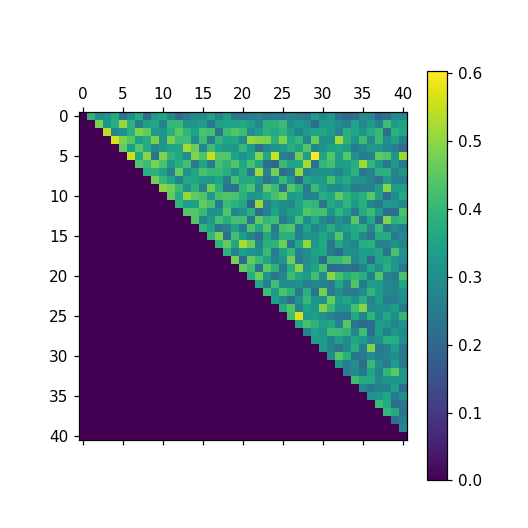

0.200187991057719
0.6027342967788474


In [47]:
dist_params_mat = np.zeros((len(target_samples_idxs), len(target_samples_idxs)))
for i in np.arange(len(target_samples_idxs)):
    for j in np.arange(i+1, len(target_samples_idxs)):
        p1 = random_samples[target_samples_idxs[i]]
        p2 = random_samples[target_samples_idxs[j]]
        cost = distance.cosine(p1, p2)
        dist_params_mat[i, j] =  cost
dist_params_array = dist_params_mat[dist_params_mat>0].ravel()

plt.matshow(dist_params_mat)
plt.colorbar()

print(np.min(dist_params_array))
print(np.max(dist_params_array))

<IPython.core.display.Javascript object>


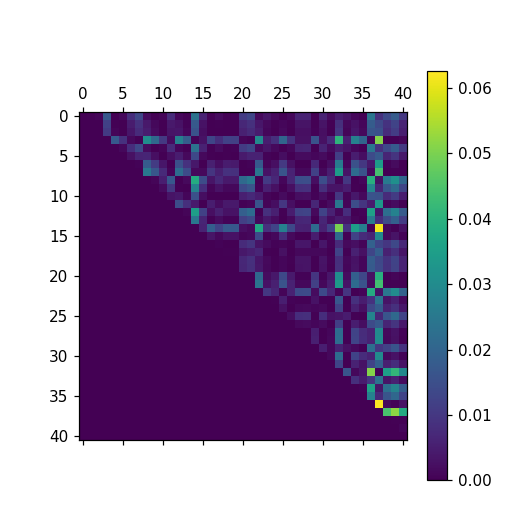

3.26367165071062e-07
0.06250174115318086


In [48]:
dist_sc_params_mat = np.zeros((len(target_samples_idxs), len(target_samples_idxs)))
for i in np.arange(len(target_samples_idxs)):
    for j in np.arange(i+1, len(target_samples_idxs)):
        p1 = scaled_samples[target_samples_idxs[i]]
        p2 = scaled_samples[target_samples_idxs[j]]
        cost = distance.cosine(p1, p2)
        dist_sc_params_mat[i, j] =  cost
dist_sc_params_array = dist_sc_params_mat[dist_sc_params_mat>0].ravel()

plt.matshow(dist_sc_params_mat)
plt.colorbar()

print(np.min(dist_sc_params_array))
print(np.max(dist_sc_params_array))

## Compute full set of features

In [49]:
def vectorize_features(feature_list):
    feature_vectors = []
    for feature in feature_list:
        feature_vector = {}
        for prot, prot_dict in feature.items():
            for loc, loc_feat in prot_dict.items():
                for feat, feat_val in loc_feat.items():
                    feature_vector[f'{prot}.{loc}.{feat}'] = feat_val[0]
        feature_vectors.append(feature_vector)
    return feature_vectors

In [50]:
mea_positions = np.zeros((20, 3))
mea_positions[:, 2] = 20
mea_positions[:, 1] = np.linspace(-500, 1000, 20)
probe = mu.return_mea(info={'pos': list([list(p) for p in mea_positions]), 'center': False, 'plane': 'xy'})
electrode = LFPy.RecExtElectrode(probe=probe, method='linesource')

In [51]:
channels = None

morphology = ephys.morphologies.NrnFileMorphology('morphology/C060114A7.asc', do_replace_axon=True)
param_configs = json.load(open('config/parameters.json'))
parameters = l5pc_model.define_parameters()
mechanisms = l5pc_model.define_mechanisms()

l5pc_cell = ephys.models.LFPyCellModel('l5pc', 
                                       v_init=-65., 
                                       morph=morphology, 
                                       mechs=mechanisms, 
                                       params=parameters)

param_names = [param.name for param in l5pc_cell.params.values() if not param.frozen]      
feature_set = 'all'

print(f'Feature set {feature_set}')
gt_responses = []

if feature_set in ["extra", "all"]:
    fitness_protocols = l5pc_evaluator.define_protocols(electrode) 
else:
    fitness_protocols = l5pc_evaluator.define_protocols() 

if feature_set in ["extra", "all"]:
    sim = ephys.simulators.LFPySimulator(LFPyCellModel=l5pc_cell, cvode_active=True, electrode=electrode)
else:
    sim = ephys.simulators.LFPySimulator(LFPyCellModel=l5pc_cell, cvode_active=True)

Feature set all


In [52]:
random_params = pd.DataFrame(data=scaled_samples[np.array(target_samples_idxs)], columns=param_lims.keys(), 
                             index=[f'random_{i}' for i in range(len(target_samples_idxs))])

In [53]:
random_params

,gNaTs2_tbar_NaTs2_t.apical,gSKv3_1bar_SKv3_1.apical,gImbar_Im.apical,gNaTa_tbar_NaTa_t.axonal,gK_Tstbar_K_Tst.axonal,gamma_CaDynamics_E2.axonal,gNap_Et2bar_Nap_Et2.axonal,gSK_E2bar_SK_E2.axonal,gCa_HVAbar_Ca_HVA.axonal,gK_Pstbar_K_Pst.axonal,gSKv3_1bar_SKv3_1.axonal,decay_CaDynamics_E2.axonal,gCa_LVAstbar_Ca_LVAst.axonal,gamma_CaDynamics_E2.somatic,gSKv3_1bar_SKv3_1.somatic,gSK_E2bar_SK_E2.somatic,gCa_HVAbar_Ca_HVA.somatic,gNaTs2_tbar_NaTs2_t.somatic,decay_CaDynamics_E2.somatic,gCa_LVAstbar_Ca_LVAst.somatic
random_0,0.023489,0.004067,0.000147,3.723998,0.076630,0.002672,0.006481,0.007159,0.000939,0.972736,0.835313,279.420027,0.009840,0.000715,0.298929,0.008940,0.000920,0.874102,232.971663,0.000330
random_1,0.031142,0.004463,0.000152,2.544693,0.072787,0.002696,0.006324,0.007016,0.000828,0.819930,1.088841,238.095239,0.007322,0.000549,0.320150,0.007656,0.000859,0.953193,186.516859,0.000388
random_2,0.026959,0.003508,0.000120,3.558753,0.098947,0.003407,0.007452,0.007453,0.000801,0.816496,0.818492,271.171790,0.008709,0.000535,0.338924,0.009920,0.000824,0.827280,208.272812,0.000272
random_3,0.022966,0.004842,0.000119,2.672051,0.073076,0.002534,0.006537,0.006245,0.000965,0.793601,0.876891,341.466134,0.008363,0.000588,0.306827,0.007008,0.000803,0.895536,190.452616,0.000387
random_4,0.024599,0.003897,0.000121,3.141731,0.097607,0.002755,0.005472,0.007173,0.000829,0.799156,1.197675,252.024961,0.007134,0.000554,0.257920,0.009400,0.000906,0.838741,210.279748,0.000299
random_5,0.025960,0.003702,0.000116,3.730761,0.080065,0.002486,0.007869,0.006287,0.000798,0.782988,0.868480,263.723366,0.009266,0.000652,0.262259,0.006796,0.000912,0.887467,197.447675,0.000268
random_6,0.021559,0.004327,0.000132,2.836562,0.079587,0.003340,0.005871,0.006186,0.000826,0.925720,0.883873,268.451771,0.007441,0.000514,0.270772,0.008498,0.000969,0.796352,170.869173,0.000340
random_7,0.025879,0.004319,0.000142,2.786307,0.072197,0.002729,0.007915,0.005942,0.000823,0.885143,1.217044,304.745851,0.007009,0.000671,0.316801,0.006787,0.000839,0.882016,179.180269,0.000282
random_8,0.021426,0.004015,0.000152,2.675397,0.075368,0.003127,0.005811,0.008373,0.000955,0.944851,1.170982,253.942693,0.009797,0.000584,0.268328,0.007164,0.000812,0.909089,239.441373,0.000308
random_9,0.030555,0.003600,0.000116,2.634830,0.099634,0.002421,0.007441,0.005730,0.000829,0.821356,0.950580,270.781801,0.008486,0.000622,0.260814,0.008316,0.000981,0.981358,234.790790,0.000292


In [54]:
random_features = []
random_responses = []

for i, (index, params) in enumerate(random_params.iterrows()):
    print(f'{i+1} / {len(random_params)}, {index}')
    
    feature_folder = f'config/features/{index}'
    _, response, feature_dict = l5pc_evaluator.compute_feature_values(params, l5pc_cell, fitness_protocols, sim, 
                                                                      feature_set=feature_set, probe=probe, 
                                                                      channels=channels,
                                                                      feature_folder=feature_folder,
                                                                      save_to_file=False)
    random_features.append(feature_dict)
    random_responses.append(response)

1 / 41, random_0
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
2 / 41, random_1
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
3 / 41, random_2
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
4 / 41, random_3
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
5 / 41, random_4
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
6 / 41, random_5
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
7 / 41, random_6
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
8 / 41, random_7
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
9 / 41, random_8
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
10 / 41, random_9
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
11 / 41, random_10
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
12 / 41, random_11
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
13 / 41, random_12
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
14 / 41, random_13
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
15 / 41, random_14
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
16 / 41, random_15
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
17 / 41, random_16
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
18 / 41, random_17
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
19 / 41, random_18
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
20 / 41, random_19
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
21 / 41, random_20
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
22 / 41, random_21
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
23 / 41, random_22
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
24 / 41, random_23
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
25 / 41, random_24
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
26 / 41, random_25
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
27 / 41, random_26
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
28 / 41, random_27
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
29 / 41, random_28
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
30 / 41, random_29
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
31 / 41, random_30
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
32 / 41, random_31
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
33 / 41, random_32
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
34 / 41, random_33
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
35 / 41, random_34
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
36 / 41, random_35
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
37 / 41, random_36
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
38 / 41, random_37
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
39 / 41, random_38
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
40 / 41, random_39
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150
41 / 41, random_40
Running bAP


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step3


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step2


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


Running Step1


/Users/abuccino/Documents/Codes/modeling/BluePyOpt/bluepyopt/ephys/simulators.py:76: UserWarning: Unable to find Neuron hoc shared library in /Applications/NEURON-7.7/nrn/lib/python/neuron, not disabling banner
  'not disabling banner' % nrnpy_path)


bAP Num features: 5
Step3 Num features: 10
Step2 Num features: 10
Step1 Num features: 150


### Exclude params that do not express bAP firing

In [56]:
random_features_v = vectorize_features(random_features)

In [79]:
complete_bap = []
for i, gt in enumerate(list(random_features_v)):
    bap_feat = [k for k in gt.keys() if 'bAP' in k]
    if len(bap_feat) == 5:
        complete_bap.append(i)
bap_sample_idxs = np.array(complete_bap)
print(f"Samples with complete bAP response: {len(complete_bap)} / {len(random_features_v)}")
bap_features_v = np.array(random_features_v)[bap_sample_idxs]
bap_responses = np.array(random_responses)[bap_sample_idxs]
bap_scaled_samples = scaled_samples[np.array(bap_sample_idxs)]
bap_random_samples = random_samples[np.array(bap_sample_idxs)]

Samples with complete bAP response: 27 / 41


In [80]:
# We can select a subset of extracellular channels to compute features on (if None, all channels are used)
channels=None

<IPython.core.display.Javascript object>


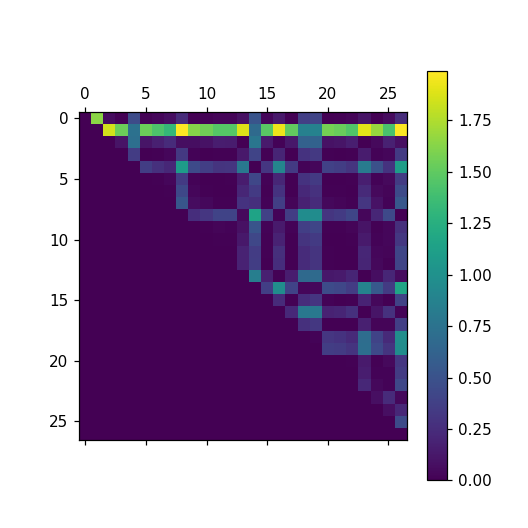

0.00010551967667304929
1.9882997428787081


In [81]:
dist_feat_mat = np.zeros((len(bap_sample_idxs), len(bap_sample_idxs)))
for i in np.arange(len(bap_sample_idxs)):
    for j in np.arange(i+1, len(bap_sample_idxs)):
        f1 = bap_features_v[i]
        f2 = bap_features_v[j]
        
        selected_keys = []
        for k in f1.keys():
            if 'MEA' not in k:
                selected_keys.append(k)
            else:
                if channels is not None:
                    if int(k[-1]) in channels:
                        selected_keys.append(k)
                else:
                    selected_keys.append(k)
                        
        f1_val, f2_val = [], []
        for k in selected_keys:
            if k in f1 and k in f2:
                if np.isfinite(f1[k]) and np.isfinite(f2[k]):
                    f1_val.append(f1[k])
                    f2_val.append(f2[k])
        cost = distance.cosine(f1_val, f2_val)
        if np.isnan(cost):
            print(f1_val, f2_val)
        dist_feat_mat[i, j] =  cost
        
dist_feat_array = dist_feat_mat[dist_feat_mat>0].ravel()

plt.matshow(dist_feat_mat)
plt.colorbar()

print(np.min(dist_feat_array))
print(np.max(dist_feat_array))

## Select samples with the most distant features

In [82]:
num_final_samples = 5

<IPython.core.display.Javascript object>


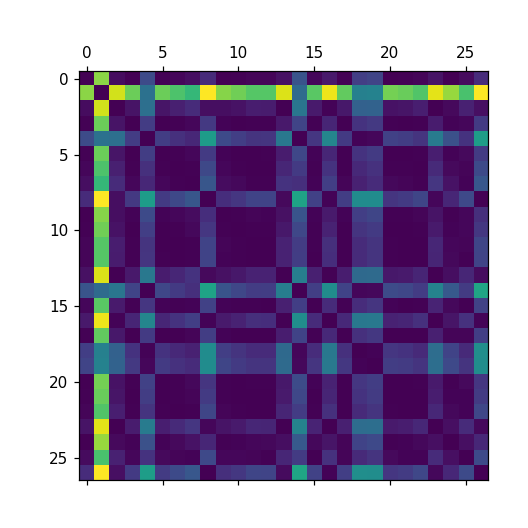

In [83]:
# make dist_matrix symmetric
dist_feat_sym = copy(dist_feat_mat)

for i in np.arange(len(bap_sample_idxs)):
    for j in np.arange(i+1, len(bap_sample_idxs)):
        dist_feat_sym[j, i] = dist_feat_sym[i, j]
plt.matshow(dist_feat_sym)

In [84]:
# select samples based on cumulative distance
cum_dist = np.sum(dist_feat_sym, 0)
max_dist_idxs = np.argsort(cum_dist)[::-1][:num_final_samples]

In [85]:
print(cum_dist[max_dist_idxs])

[38.96278294 13.10340923 12.28092499 12.04957809 11.8310617 ]


In [71]:
selected_sample_idxs = max_dist_idxs

In [86]:
selected_scaled_params = bap_scaled_samples[selected_sample_idxs]
selected_random_params = bap_random_samples[selected_sample_idxs]
selected_responses = bap_responses[selected_sample_idxs]
selected_features_v = bap_features_v[selected_sample_idxs]

<IPython.core.display.Javascript object>


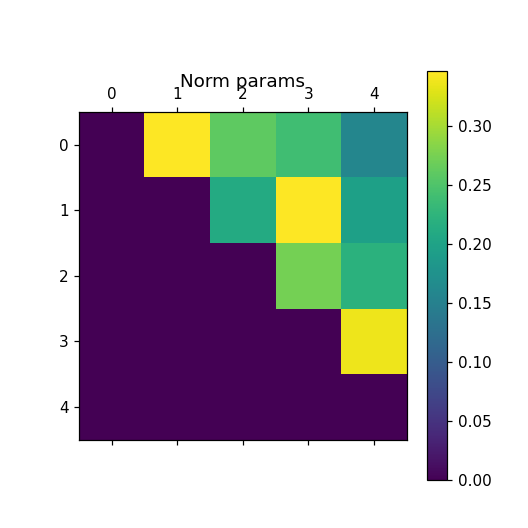

<IPython.core.display.Javascript object>


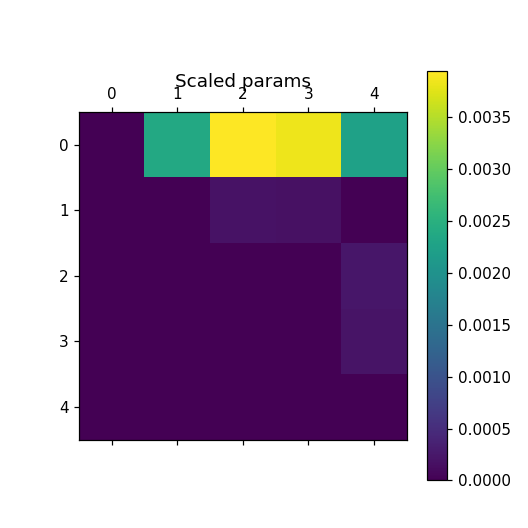

<IPython.core.display.Javascript object>


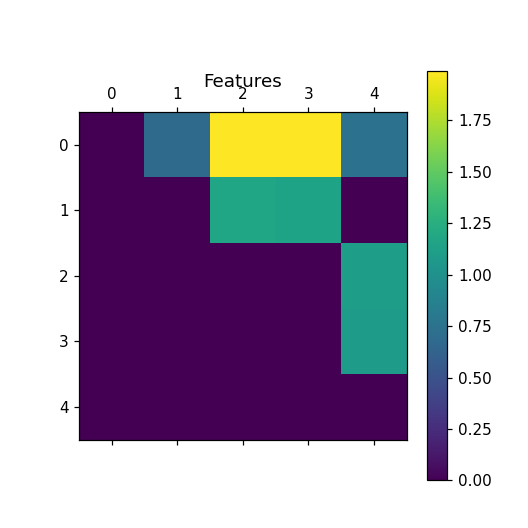

In [88]:
dist_sel_random_params_mat = np.zeros((len(selected_random_params), len(selected_random_params)))
dist_sel_scaled_params_mat = np.zeros((len(selected_random_params), len(selected_random_params)))
dist_sel_features_mat = np.zeros((len(selected_random_params), len(selected_random_params)))
for i in np.arange(len(selected_random_params)):
    for j in np.arange(i+1, len(selected_random_params)):
        p1 = selected_random_params[i]
        p2 = selected_random_params[j]
        dist_sel_random_params_mat[i, j] =  distance.cosine(p1, p2)
        
        p1 = selected_scaled_params[i]
        p2 = selected_scaled_params[j]
        dist_sel_scaled_params_mat[i, j] =  distance.cosine(p1, p2)
        
        f1 = selected_features_v[i]
        f2 = selected_features_v[j]
        
        selected_keys = []
        for k in f1.keys():
            if 'MEA' not in k:
                selected_keys.append(k)
            else:
                if channels is not None:
                    if int(k[-1]) in channels:
                        selected_keys.append(k)
                else:
                    selected_keys.append(k)
                        
        f1_val, f2_val = [], []
        for k in selected_keys:
            if k in f1 and k in f2:
                if np.isfinite(f1[k]) and np.isfinite(f2[k]):
                    f1_val.append(f1[k])
                    f2_val.append(f2[k])
        dist_sel_features_mat[i, j] = distance.cosine(f1_val, f2_val)
        
# dist_params_array = dist_params_mat[dist_params_mat>0].ravel()

plt.matshow(dist_sel_random_params_mat)
plt.title("Norm params")
plt.colorbar()

plt.matshow(dist_sel_scaled_params_mat)
plt.title("Scaled params")
plt.colorbar()

plt.matshow(dist_sel_features_mat)
plt.title("Features")
plt.colorbar()

# print(np.min(dist_params_array))
# print(np.max(dist_params_array))

<IPython.core.display.Javascript object>


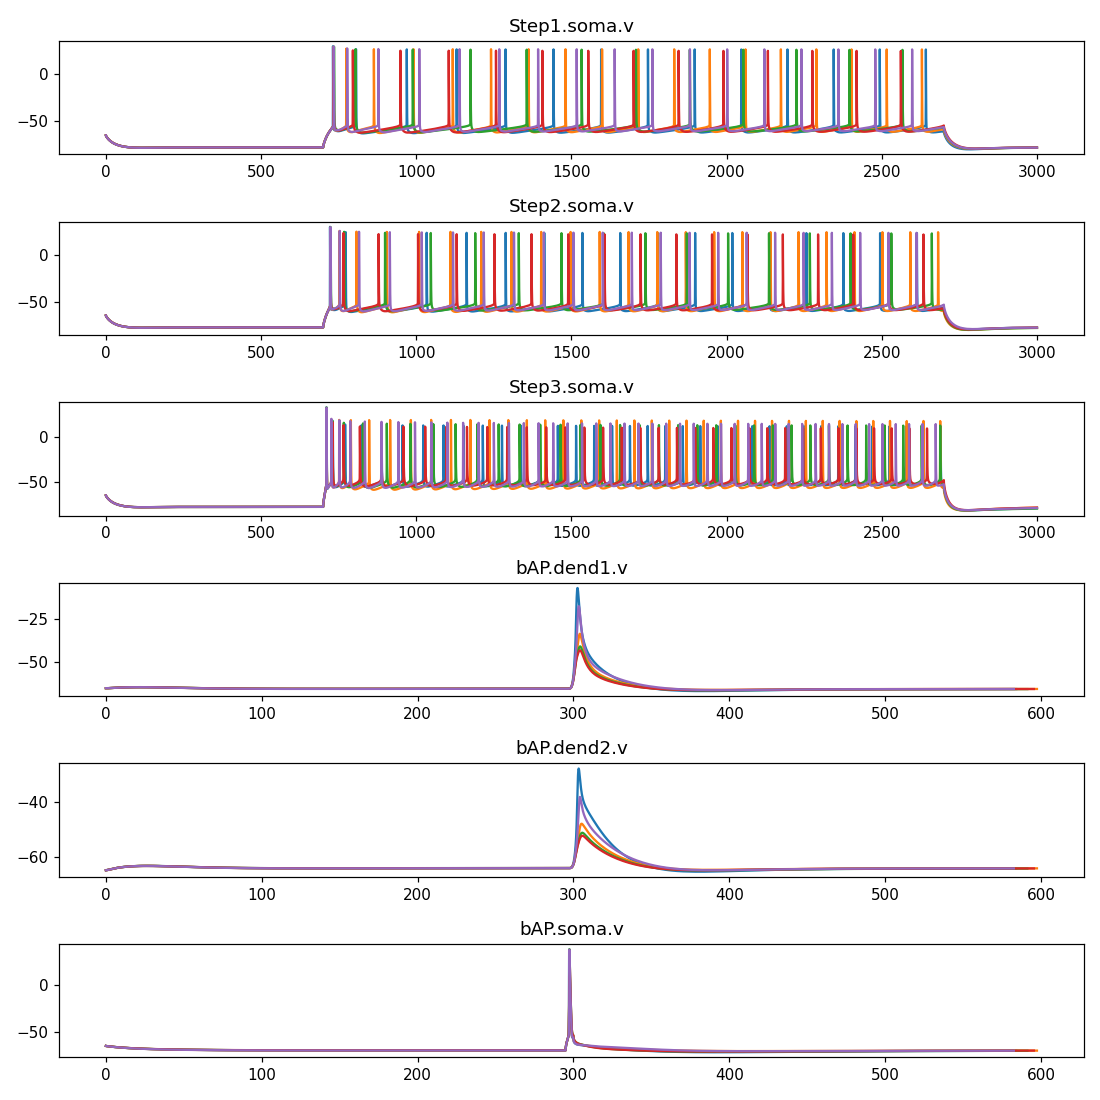

In [90]:
l5pc_plot.plot_multiple_responses(responses_list=selected_responses)

In [94]:
for f in selected_features_v:
    print(len([k for k in f.keys() if 'bAP' in k]))

5
5
5
5
5


In [95]:
# creata dataframe
df_release = pd.DataFrame(data=release_params, index=['release'])
df_random = pd.DataFrame(data=selected_scaled_params, columns=param_lims.keys(), 
                         index=[f'random_{i}' for i in range(len(selected_scaled_params))])

In [96]:
df_random

,gNaTs2_tbar_NaTs2_t.apical,gSKv3_1bar_SKv3_1.apical,gImbar_Im.apical,gNaTa_tbar_NaTa_t.axonal,gK_Tstbar_K_Tst.axonal,gamma_CaDynamics_E2.axonal,gNap_Et2bar_Nap_Et2.axonal,gSK_E2bar_SK_E2.axonal,gCa_HVAbar_Ca_HVA.axonal,gK_Pstbar_K_Pst.axonal,gSKv3_1bar_SKv3_1.axonal,decay_CaDynamics_E2.axonal,gCa_LVAstbar_Ca_LVAst.axonal,gamma_CaDynamics_E2.somatic,gSKv3_1bar_SKv3_1.somatic,gSK_E2bar_SK_E2.somatic,gCa_HVAbar_Ca_HVA.somatic,gNaTs2_tbar_NaTs2_t.somatic,decay_CaDynamics_E2.somatic,gCa_LVAstbar_Ca_LVAst.somatic
random_0,0.023152,0.004740,0.000134,3.165824,0.099322,0.003146,0.007447,0.007767,0.000804,0.964647,0.917445,302.488532,0.008482,0.000518,0.355962,0.009732,0.000800,0.928103,239.563403,0.000321
random_1,0.027940,0.003663,0.000166,2.936390,0.080561,0.002884,0.006290,0.006642,0.000886,0.828584,1.145311,273.192963,0.007902,0.000663,0.260306,0.007415,0.000933,0.882658,248.817531,0.000291
random_2,0.025824,0.004012,0.000166,3.362440,0.088755,0.002461,0.007566,0.005911,0.000924,0.985627,0.903709,260.272565,0.008545,0.000666,0.301273,0.006860,0.000834,0.815605,246.697643,0.000385
random_3,0.021715,0.003429,0.000116,2.959096,0.080843,0.003122,0.005764,0.005878,0.000855,0.938308,0.951147,253.535492,0.009667,0.000632,0.274730,0.009851,0.000796,0.825475,239.758983,0.000350
random_4,0.026254,0.004546,0.000170,2.791356,0.097802,0.003238,0.008148,0.007373,0.000799,0.939161,1.095640,232.367288,0.009256,0.000602,0.339545,0.008332,0.000958,0.846279,210.898885,0.000292


<IPython.core.display.Javascript object>


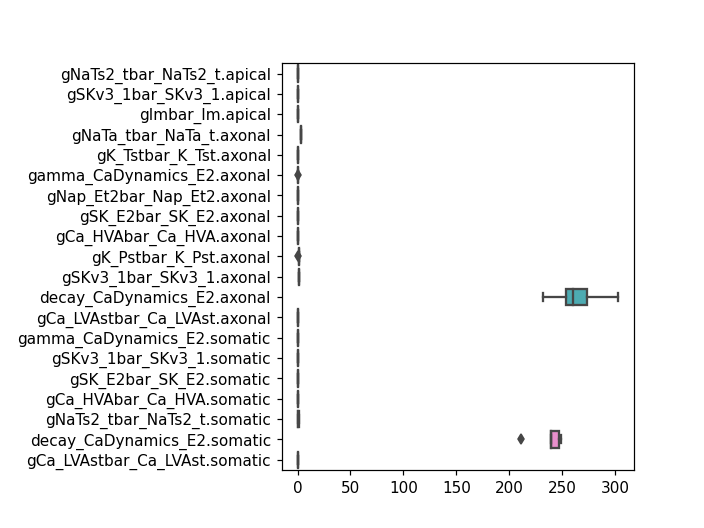

In [77]:
plt.figure()
ax = sns.boxplot(data=df_random, orient='horizontal')
fig = ax.get_figure()
fig.subplots_adjust(left=0.4)

### Save random and releas parameters to csv

In [139]:
if save_params:
    params_folder = Path('config/params')

    if not params_folder.is_dir():
        os.makedirs(params_folder)

    release_params_file = params_folder / 'release.csv'
    random_params_file = params_folder / 'smart_random.csv'

    df_release.to_csv(release_params_file, index_label='index')
    df_random.to_csv(random_params_file, index_label='index')    